In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
import sys

sys.path.append('..')

hepatitis = pd.read_csv('HepatitisDataset/hepatitis.csv')
hepatitis.shape

(155, 20)

In [2]:
hepatitis.isna().value_counts()

Class  AGE    SEX    STEROID  ANTIVIRALS  FATIGUE  MALAISE  ANOREXIA  LIVER BIG  LIVER FIRM  SPLEEN PALPABLE  SPIDERS  ASCITES  VARICES  BILIRUBIN  ALK PHOSPHATE  SGOT   ALBUMIN  PROTIME  HISTOLOGY
False  False  False  False    False       False    False    False     False      False       False            False    False    False    False      False          False  False    False    False        155
dtype: int64

In [3]:
hepatitis['Class'] = hepatitis['Class'] - 1

In [4]:
X = hepatitis.iloc[:,1:]
y = hepatitis['Class']

In [5]:
from sklearn.model_selection import train_test_split

train, test, labels_train, labels_test = train_test_split(X, y,
                                                          train_size=0.70, test_size=0.30,
                                                          random_state=2022)

In [6]:
categorical_features = np.argwhere(
    np.array([len(set(X.iloc[:, x])) for x in range(X.shape[1])]) <= 10).flatten()
categorical_features

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 18], dtype=int64)

In [7]:
categorical_features = np.argwhere(
    np.array([len(set(X.iloc[:, x])) for x in range(X.shape[1])]) <= 10).flatten()
categorical_features

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 18], dtype=int64)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical

model = RandomForestClassifier(random_state=2022)
# model = AdaBoostClassifier(random_state=2022)
# model = GradientBoostingClassifier(random_state=2022)
# labels_train2 = to_categorical(labels_train, 2)
# labels_test2 = to_categorical(labels_test, 2)
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=30))
# model.add(Dropout(0.2))
# model.add(Dense(2, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# model.fit(train, labels_train2, batch_size=32, epochs=50, validation_data=(test, labels_test2))
model.fit(train, labels_train)

Using TensorFlow backend.


RandomForestClassifier(random_state=2022)

In [9]:
pred_origin = model.predict_proba(test)
pred_origin = np.argmax(pred_origin, axis=1)
pred_origin[:5]

array([1, 1, 1, 1, 0], dtype=int64)

In [10]:
from sklearn.preprocessing import MinMaxScaler

feature_importances = MinMaxScaler().fit_transform(model.feature_importances_.reshape(-1, 1))
feature_importances = feature_importances.flatten()
feature_importances

array([0.64126577, 0.07689402, 0.1210462 , 0.        , 0.14167139,
       0.27816495, 0.07322541, 0.19831977, 0.1942568 , 0.24210851,
       0.2165928 , 0.51319336, 0.18514314, 1.        , 0.53322414,
       0.60282448, 0.96812273, 0.27612416, 0.37695105])

In [11]:
import lime
import lime.lime_tabular

feature_names = hepatitis.columns.values.tolist()[1:]
explainer = lime.lime_tabular.LimeTabularExplainer(train.values, feature_names=feature_names
                                                   , categorical_features=categorical_features
                                                   , verbose=False
                                                   , mode='classification'
                                                   , random_state=2022
                                                   # , discretize_continuous = False
                                                   )

5.948781734564771e-05
0.9456783493788993
{0: [(16, 7.816028579356225), (11, -7.0289186571408315), (18, -5.571946681498503), (5, 4.668116488703573), (13, 3.5456988725852727), (0, -2.7643876573046446), (6, 2.71374206902565), (10, 2.0313549977658365), (14, -1.9837862212010553), (7, -1.6376473643256122), (4, 1.3030667118801738), (15, 1.139316575291619), (12, -1.1359254127073546), (8, 0.8473018187958755), (1, 0.81812297890366), (17, -0.7729170272203141), (2, -0.353794778617123), (9, 0.10239934303555878), (3, -0.0950683983058582)], 1: [(16, -3.6245560035831748), (11, 3.1247398654322924), (13, -2.4064429652694637), (18, 2.3428748470923177), (5, -1.6061509196924935), (14, 1.3252714957670415), (7, 1.239647143541901), (10, -1.171002002323332), (4, -1.0584243086749996), (15, -0.8856999156655454), (6, -0.8486048395245502), (1, -0.7859387568114997), (9, 0.6928847086995913), (12, 0.6920530935080855), (8, -0.6776130977046845), (17, 0.27289790731388924), (0, -0.12924620676977194), (2, 0.10850641725873

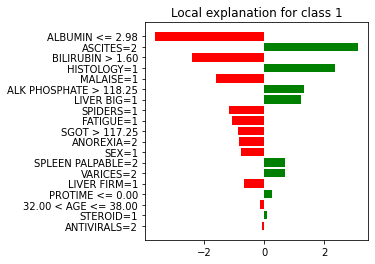

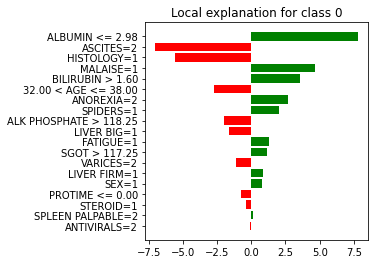

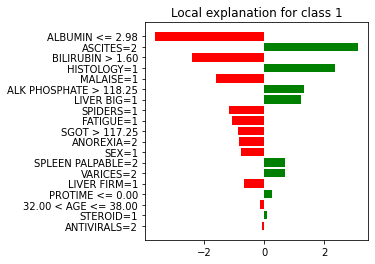

In [12]:
exp = explainer.explain_instance(test.values[25], model.predict_proba, num_features=19,
                                 labels=(0, 1), num_samples=5000
                                 # , model_regressor='ensemble'
                                 )
print(exp.local_pred[0])
print(exp.local_pred[1])
print(exp.local_exp)
exp.as_pyplot_figure(label=0)
exp.as_pyplot_figure(label=1)

In [13]:
import tqdm as td
from sklearn.metrics.pairwise import cosine_similarity
pred_lime = []
cos_sim_list = []
for k in td.tqdm(test.values):
    exp = explainer.explain_instance(k, model.predict_proba, num_features=19, labels=(0, 1)
                                     ,model_regressor='ensemble'
                                     , num_samples=5000
                                     )
    # print(exp.local_pred)
    pred_lime.append([exp.local_pred[0], exp.local_pred[1]])
    coef_list = np.zeros(len(feature_names))
    # print(len(exp.local_exp))
    for i in exp.local_exp:
        # print(exp.local_exp[i])
        for j in exp.local_exp[i]:
            if isinstance(j[1], np.ndarray):
                coef_list[j[0]] += j[1].tolist()[0]
            else:
                coef_list[j[0]] += j[1]
    coef_list = coef_list / len(exp.local_exp)
    coef_list = MinMaxScaler().fit_transform(coef_list.reshape(-1, 1)).flatten()
    # print(coef_list)
    importance_coef = []
    importance_coef.append(feature_importances.tolist())
    importance_coef.append(coef_list.tolist())
    # print(importance_coef)
    # print('cos_sim:', cosine_similarity(importance_coef)[0][1])
    cos_sim_list.append(cosine_similarity(importance_coef)[0][1])
print(np.sum(cos_sim_list) / len(cos_sim_list))

100%|██████████| 47/47 [00:35<00:00,  1.31it/s]

0.6642849052839607


In [14]:
pred_lime = np.argmax(pred_lime, axis=1)
pred_lime[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [15]:
from sklearn.metrics import classification_report

print('\nClassification Report:\n', classification_report(labels_test, pred_origin, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     0.6000    0.3000    0.4000        10
           1     0.8333    0.9459    0.8861        37

    accuracy                         0.8085        47
   macro avg     0.7167    0.6230    0.6430        47
weighted avg     0.7837    0.8085    0.7827        47



In [16]:
print('\nClassification Report:\n', classification_report(labels_test, pred_lime, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.1000    0.1667        10
           1     0.8000    0.9730    0.8780        37

    accuracy                         0.7872        47
   macro avg     0.6500    0.5365    0.5224        47
weighted avg     0.7362    0.7872    0.7267        47



In [17]:

print('\nClassification Report:\n', classification_report(pred_origin, pred_lime, digits=4))



Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.4000    0.5714         5
           1     0.9333    1.0000    0.9655        42

    accuracy                         0.9362        47
   macro avg     0.9667    0.7000    0.7685        47
weighted avg     0.9404    0.9362    0.9236        47

